# Collecting Data

In [ ]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
!tar -zxvf UrbanSound8K.tar.gz
!rm -rf UrbanSound8K.tar.gz

Output streaming akan dipotong hingga 5000 baris terakhir.
UrbanSound8K/audio/fold4/17480-2-0-6.wav
UrbanSound8K/audio/fold4/17480-2-0-9.wav
UrbanSound8K/audio/fold4/175904-2-0-11.wav
UrbanSound8K/audio/fold4/175904-2-0-24.wav
UrbanSound8K/audio/fold4/176003-1-0-0.wav
UrbanSound8K/audio/fold4/176638-5-0-0.wav
UrbanSound8K/audio/fold4/177756-2-0-10.wav
UrbanSound8K/audio/fold4/177756-2-0-4.wav
UrbanSound8K/audio/fold4/177756-2-0-5.wav
UrbanSound8K/audio/fold4/177756-2-0-7.wav
UrbanSound8K/audio/fold4/179862-1-0-0.wav
UrbanSound8K/audio/fold4/180977-3-1-1.wav
UrbanSound8K/audio/fold4/180977-3-1-5.wav
UrbanSound8K/audio/fold4/183989-3-1-21.wav
UrbanSound8K/audio/fold4/183989-3-1-23.wav
UrbanSound8K/audio/fold4/185709-0-0-0.wav
UrbanSound8K/audio/fold4/185709-0-0-1.wav
UrbanSound8K/audio/fold4/185709-0-0-6.wav
UrbanSound8K/audio/fold4/185709-0-0-7.wav
UrbanSound8K/audio/fold4/185909-2-0-102.wav
UrbanSound8K/audio/fold4/185909-2-0-13.wav
UrbanSound8K/audio/fold4/185909-2-0-17.wav
UrbanSound

# Import Library

In [ ]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io import wavfile as wav

# Mini EDA

In [ ]:
filename = os.path.join('UrbanSound8K', 'audio', 'fold5', '100263-2-0-3.wav')

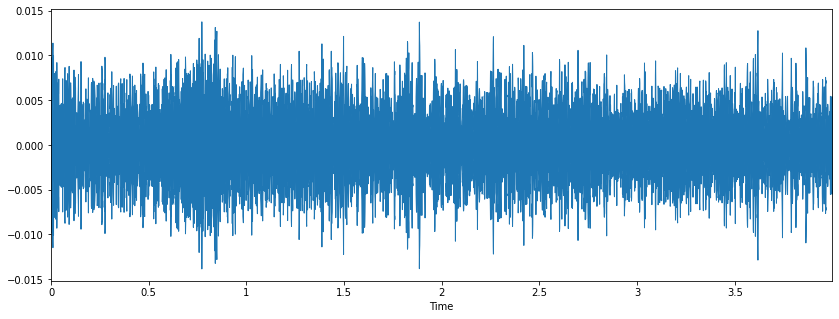

In [ ]:
plt.figure(figsize=(14,5))
librosa_audio_data, librosa_sample_rate = librosa.load(filename)
librosa.display.waveplot(librosa_audio_data, sr=librosa_sample_rate)
ipd.Audio(filename)


In [ ]:
wave_sample_rate, wave_audio = wav.read(filename)

### Different Things Between Librosa and Scipy WAV

Librosa: Data Normalized and Mono Channel<br>
Scipy: Data Actual (Not Normalized) and Stereo Channel

In [ ]:
print(f'Librosa (Normalized): {librosa_audio_data}')
print(f'Scipy (Raw): {wave_audio}')

Librosa (Normalized): [ 0.00330576  0.00468387  0.00360455 ... -0.0037562  -0.00348641
 -0.00356705]
Scipy (Raw): [[ 194  100]
 [ 179  113]
 [ 160  124]
 ...
 [-143  -87]
 [-134  -91]
 [-110  -98]]


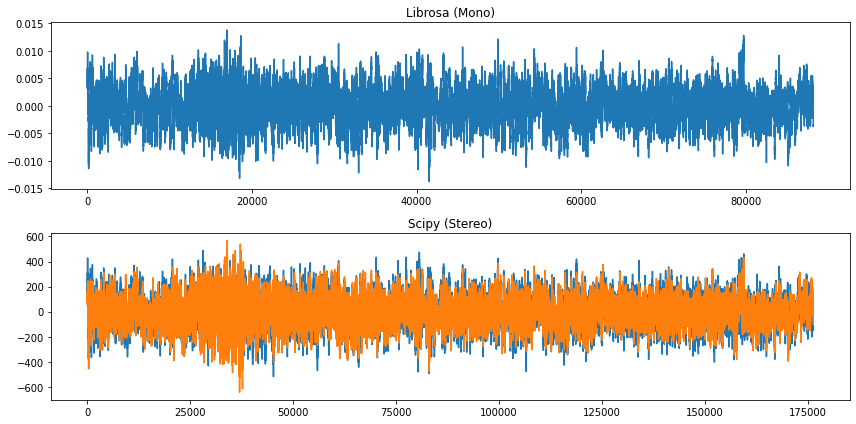

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(librosa_audio_data);
plt.title('Librosa (Mono)')
plt.subplot(212)
plt.plot(wave_audio);
plt.title('Scipy (Stereo)')
plt.tight_layout()

# Import Data

In [ ]:
metadata_csv = os.path.join('UrbanSound8K', 'metadata', 'UrbanSound8K.csv')
metadata = pd.read_csv(metadata_csv)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
# Check whether the dataset is imbalanced
metadata['class'].value_counts()

jackhammer          1000
drilling            1000
street_music        1000
air_conditioner     1000
children_playing    1000
engine_idling       1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

# Extract Feature

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [ ]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [ ]:
mfccs_scaled_features = np.mean(mfccs.T, axis=0)

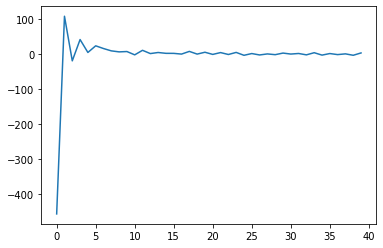

In [ ]:
plt.plot(mfccs_scaled_features)

In [ ]:
# Extracting MFSS's For Every Audio File

audio_dataset_path = os.path.join('UrbanSound8K', 'audio')
metadata_csv = os.path.join('UrbanSound8K', 'metadata', 'UrbanSound8K.csv')

metadata = pd.read_csv(metadata_csv)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
def feature_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_feature.T, axis=0)

    return mfccs_scaled_features

In [ ]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = feature_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3555it [05:15, 10.83it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8325it [12:06, 15.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [12:40, 11.49it/s]


In [ ]:
# Converting extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265705,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [ ]:
# Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(8732, 40)

In [ ]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train.shape, y_train.shape

((6985, 40), (6985, 10))

# Build Model Classification

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
# Number of Classes
num_labels = y.shape[1]

In [ ]:
model = Sequential()
# First Layer
model.add(Dense(100, input_shape=(40,), activation='relu'))
model.add(Dropout(0.5))
# Second Layer
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
# Third Layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Final Layer
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [ ]:
# Training My Model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train,
          batch_size=num_batch_size,
          epochs=num_epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpointer],
          verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 0.8422 - accuracy: 0.7221 - val_loss: 0.6691 - val_accuracy: 0.7888

Epoch 00001: val_loss improved from inf to 0.66910, saving model to saved_models/audio_classification.hdf5
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 0.8769 - accuracy: 0.7081 - val_loss: 0.6661 - val_accuracy: 0.7951

Epoch 00002: val_loss improved from 0.66910 to 0.66614, saving model to saved_models/audio_classification.hdf5
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 0.8496 - accuracy: 0.7207 - val_loss: 0.6587 - val_accuracy: 0.8002

Epoch 00003: val_loss improved from 0.66614 to 0.65872, saving model to saved_models/audio_classification.hdf5
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 0.8300 - accuracy: 0.7253 - val_loss: 0.6650 - val_accuracy: 0.7876

Epoch 00004: val_loss did not improve from 0.65872
Epoch 5/100
219/219 [=======================

# Evaluation

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8013737797737122


In [ ]:
prediction_feature = feature_extractor(filename)
prediction_feature = prediction_feature.reshape(1, -1)
result = np.argmax(model.predict(prediction_feature))
prediction_class = labelencoder.inverse_transform([result])
prediction_class[0]

'children_playing'